In [ ]:
from google.colab import files

uploaded = files.upload()

Saving meia-2025-sargazo-prediction.zip to meia-2025-sargazo-prediction.zip


In [ ]:
import zipfile
import os

# Ruta al archivo zip subido
zip_path = "/content/meia-2025-sargazo-prediction.zip"

# Ruta destino
extract_path = "/content/sargazo_dataset"

# Extraer
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Descompresión completa.")

Descompresión completa.


In [ ]:
import os

for root, dirs, files in os.walk("/content/sargazo_dataset"):
    print(f"\n📁 Carpeta: {root}")
    for name in files:
        print(f" - {name}")

In [ ]:
LABELS_CSV = os.path.join(extract_path, 'labels', 'labels.csv')
TEST_CSV   = os.path.join(extract_path, 'test.csv')  # si aplica
IMG_FOLDER = os.path.join(extract_path, 'images')

In [ ]:
print("LABELS CSV:", os.path.exists(LABELS_CSV))
print("IMG_FOLDER:", os.path.exists(IMG_FOLDER))

LABELS CSV: True
IMG_FOLDER: True


In [ ]:
# Sargazo Classification - Kaggle Submission Pipeline (adaptado para Colab)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Rutas de Kaggle dataset (ajusta si cambia)
LABELS_CSV = '/content/sargazo_dataset/labels/labels.csv'
TEST_CSV = '/content/sargazo_dataset/labels/test.csv'  # revisa si este es el nombre correcto
IMG_FOLDER = '/content/sargazo_dataset/images'

# Clases y mappings
class2id = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {v: k for k, v in class2id.items()}
num_classes = len(class2id)

# Transformaciones para train y validación
input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Dataset PyTorch
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)  # reset índice
        self.root_dir = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']  # nombre correcto de columna
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label_str = self.dataframe.iloc[idx]['label'].strip().lower()
        label = class2id.get(label_str, class2id['nada'])
        if self.transform:
            image = self.transform(image)
        return image, label

# Inicializar modelo MobileNetV2
def initialize_model():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)  # nueva forma recomendada
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=5):
    best_model_wts = model.state_dict()
    best_f1 = 0.0

    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_preds = []
            running_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(running_labels, running_preds, average='weighted')

            print(f"{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f}")

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = model.state_dict()

            if phase == 'train':
                train_f1_history.append(epoch_f1)
            else:
                val_f1_history.append(epoch_f1)

    model.load_state_dict(best_model_wts)
    return model, train_f1_history, val_f1_history

# Función predicción
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# Cargar datos
try:
    labels_df = pd.read_csv(LABELS_CSV)
    test_df = pd.read_csv(TEST_CSV)
except FileNotFoundError:
    print("Error: Archivos CSV no encontrados. Asegúrate de que las rutas sean correctas.")
    exit()

# Dividir datos de entrenamiento y validación
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42, stratify=labels_df['label'])

# Crear Datasets y DataLoaders
train_dataset = SargazoDataset(dataframe=train_df, images_path=IMG_FOLDER, transform=data_transforms['train'])
val_dataset = SargazoDataset(dataframe=val_df, images_path=IMG_FOLDER, transform=data_transforms['val'])
test_dataset = SargazoDataset(dataframe=test_df.assign(label='nada'), images_path=IMG_FOLDER, transform=data_transforms['val']) # Asigna una etiqueta dummy

batch_size = 32
dataloaders_dict = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Configurar dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Inicializar modelo
model = initialize_model().to(device)

# Definir pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar modelo
num_epochs = 10  # Puedes ajustar las épocas
model_trained, train_f1_hist, val_f1_hist = train_model(model, dataloaders_dict, criterion, optimizer, device, num_epochs=num_epochs)

# Evaluar en validación (opcional, ya se hace en el entrenamiento)
val_preds = predict(model_trained, dataloaders_dict['val'], device)
val_true = [class2id.get(l.strip().lower(), class2id['nada']) for l in val_df['label']]
print("\nReporte de Clasificación en Validación:")
print(classification_report(val_true, val_preds, target_names=class2id.keys()))

# Generar predicciones para el archivo de test
test_predictions_ids = predict(model_trained, test_dataloader, device)
test_predictions_classes = [id2class[pred] for pred in test_predictions_ids]

# Crear archivo de submission
submission_df = pd.DataFrame({'image_name': test_df['image_name'], 'label': test_predictions_classes})
submission_df.to_csv('submission.csv', index=False)

print("\nArchivo 'submission.csv' creado exitosamente.")

# Visualizar historial de F1 (opcional)
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_f1_hist, label='Train F1')
plt.plot(range(1, num_epochs + 1), val_f1_hist, label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Weighted)')
plt.title('Training and Validation F1 Score per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


Usando dispositivo: cuda:0


100%|██████████| 13.6M/13.6M [00:00<00:00, 86.1MB/s]


Epoch 1/10
train Loss: 1.1497 F1: 0.4931
val Loss: 1.0679 F1: 0.5406
Epoch 2/10
train Loss: 1.0228 F1: 0.5719
val Loss: 1.0269 F1: 0.5644
Epoch 3/10
train Loss: 0.9455 F1: 0.5939
val Loss: 0.9799 F1: 0.5978
Epoch 4/10
train Loss: 0.9386 F1: 0.5983
val Loss: 0.9303 F1: 0.6013
Epoch 5/10
train Loss: 0.9015 F1: 0.6124
val Loss: 0.9295 F1: 0.5930
Epoch 6/10
train Loss: 0.8901 F1: 0.6409
val Loss: 0.9437 F1: 0.6116
Epoch 7/10
train Loss: 0.8507 F1: 0.6346
val Loss: 1.0105 F1: 0.6144
Epoch 8/10
train Loss: 0.8641 F1: 0.6461
val Loss: 0.9115 F1: 0.6153
Epoch 9/10
train Loss: 0.7635 F1: 0.6777
val Loss: 0.9169 F1: 0.6515
Epoch 10/10
train Loss: 0.8002 F1: 0.6730
val Loss: 0.9991 F1: 0.5889

Reporte de Clasificación en Validación:
              precision    recall  f1-score   support

        nada       0.77      0.75      0.76       236
        bajo       0.49      0.54      0.52       142
    moderado       0.32      0.30      0.31        46
   abundante       0.26      0.37      0.30        

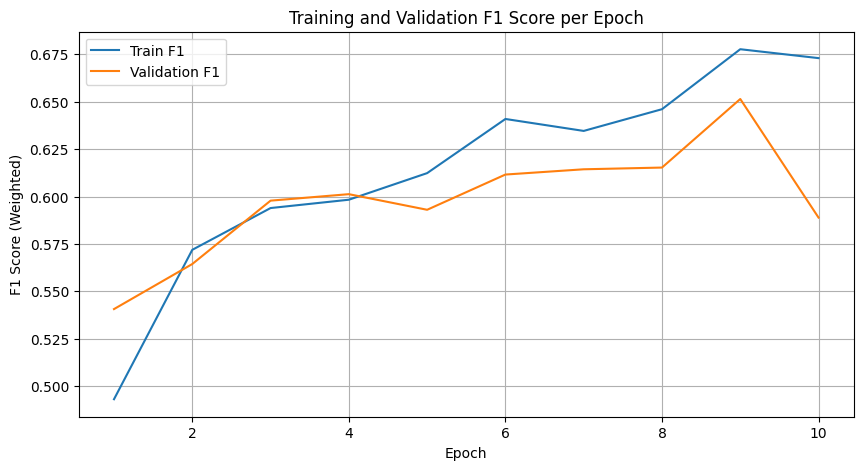

In [ ]:
# Sargazo Classification - Kaggle Submission Pipeline (adaptado para Colab)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Rutas de Kaggle dataset (ajusta si cambia)
LABELS_CSV = '/content/sargazo_dataset/labels/labels.csv'
TEST_CSV = '/content/sargazo_dataset/labels/test.csv'
IMG_FOLDER = '/content/sargazo_dataset/images'

# Clases y mappings
class2id = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {v: k for k, v in class2id.items()}
num_classes = len(class2id)

# Transformaciones para train y validación
input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Dataset PyTorch
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label_str = self.dataframe.iloc[idx]['label'].strip().lower()
        label = class2id.get(label_str, class2id['nada'])
        if self.transform:
            image = self.transform(image)
        return image, label

# Inicializar modelo MobileNetV2
def initialize_model():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model

# Entrenamiento
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=5):
    best_model_wts = model.state_dict()
    best_f1 = 0.0

    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_preds, running_labels = [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(running_labels, running_preds, average='weighted')
            print(f"{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f}")

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = model.state_dict()

            (train_f1_history if phase == 'train' else val_f1_history).append(epoch_f1)

    model.load_state_dict(best_model_wts)
    return model, train_f1_history, val_f1_history

# Predicción
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# Cargar CSVs
try:
    labels_df = pd.read_csv(LABELS_CSV)
    test_df = pd.read_csv(TEST_CSV)
except FileNotFoundError:
    print("Error: Archivos CSV no encontrados. Asegúrate de que las rutas sean correctas.")
    raise

# Dividir entrenamiento/validación
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42, stratify=labels_df['label'])

# Datasets y Dataloaders
train_dataset = SargazoDataset(train_df, IMG_FOLDER, transform=data_transforms['train'])
val_dataset = SargazoDataset(val_df, IMG_FOLDER, transform=data_transforms['val'])
test_dataset = SargazoDataset(test_df.assign(label='nada'), IMG_FOLDER, transform=data_transforms['val'])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Configurar dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Inicializar modelo y configurar entrenamiento
model = initialize_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar modelo
num_epochs = 10
model_trained, train_f1_hist, val_f1_hist = train_model(model, {'train': train_loader, 'val': val_loader}, criterion, optimizer, device, num_epochs)

# Evaluar en validación
y_val_true = [class2id[l.strip().lower()] for l in val_df['label']]
y_val_pred = predict(model_trained, val_loader, device)
print("\nReporte de Clasificación en Validación:")
print(classification_report(y_val_true, y_val_pred, target_names=class2id.keys()))

# Predicción sobre test.csv
y_test_pred_ids = predict(model_trained, test_loader, device)
y_test_pred_labels = [id2class[i] for i in y_test_pred_ids]

# Crear submission
submission_df = pd.DataFrame({
    'image_name': test_df['image_name'],
    'label': y_test_pred_labels
})
submission_df.to_csv('submission.csv', index=False)
print("\nArchivo 'submission.csv' creado exitosamente.")

# Graficar F1
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_f1_hist, label='Train F1')
plt.plot(range(1, num_epochs + 1), val_f1_hist, label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Weighted)')
plt.title('Training and Validation F1 Score per Epoch')
plt.legend()
plt.grid(True)
plt.show()


Usando dispositivo: cuda
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 1.3485 F1: 0.1757
val Loss: 1.7535 F1: 0.0414
Epoch 2/5
train Loss: 1.2383 F1: 0.2523
val Loss: 1.6437 F1: 0.0503
Epoch 3/5
train Loss: 1.1761 F1: 0.2956
val Loss: 1.6313 F1: 0.0642
Epoch 4/5
train Loss: 1.1368 F1: 0.3144
val Loss: 1.5098 F1: 0.1613
Epoch 5/5
train Loss: 1.1041 F1: 0.3434
val Loss: 1.5123 F1: 0.1919
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 1.0252 F1: 0.3757
val Loss: 1.3698 F1: 0.2713
Epoch 2/10
train Loss: 0.9255 F1: 0.4370
val Loss: 1.3080 F1: 0.3328
Epoch 3/10
train Loss: 0.8597 F1: 0.4593
val Loss: 1.2912 F1: 0.3841
Epoch 4/10
train Loss: 0.7252 F1: 0.5388
val Loss: 1.2725 F1: 0.3824
Epoch 5/10
train Loss: 0.6800 F1: 0.5650
val Loss: 1.2275 F1: 0.4655
Epoch 6/10
train Loss: 0.6057 F1: 0.6084
val Loss: 1.2510 F1: 0.4851
Epoch 7/10
train Loss: 0.5622 F1: 0.6127
val Loss: 1.2980 F1: 0.4768
Epoch 8/10
train Loss: 0.5315 F1: 0.6231
val Loss: 1.2619 F1: 0.5118
Epoch 9/10
train Loss: 0.4890 F1: 0.6756
val Loss: 1.2966 F1: 0.5020
Epoch 10/10
train Loss: 0.4731 F1: 0.6927
val Loss: 1.2740 F1: 0.5095

Reporte de clasificación en validación:
              precision    recall  f1-score   support

        nada       0.79      0.51      0.62       236
        bajo       0.47      0.35      0.40       142
    moderado       0.19      0.50      0.27        46
   abundante       0.25      0.53      0.34        30
    exce

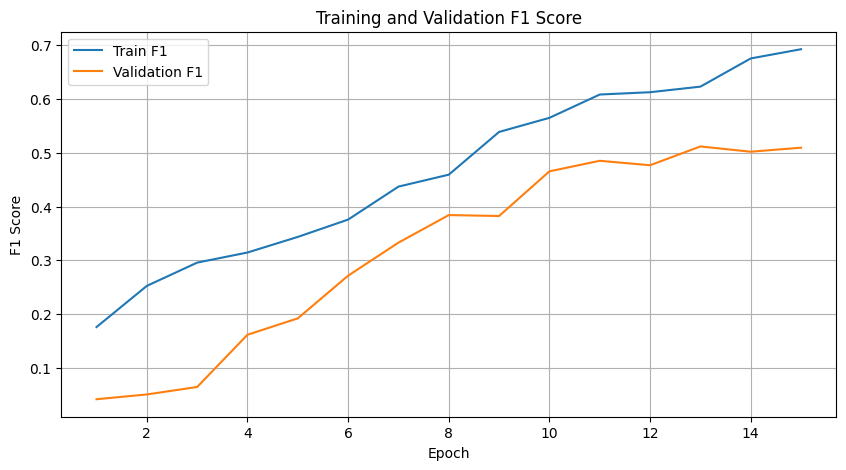

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms

# Rutas
LABELS_CSV = '/content/sargazo_dataset/labels/labels.csv'
TEST_CSV = '/content/sargazo_dataset/labels/test.csv'
IMG_FOLDER = '/content/sargazo_dataset/images'

# Clases
class2id = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {v: k for k, v in class2id.items()}
num_classes = len(class2id)

# Transforms
input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size + 32),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

# Dataset
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label_str = self.dataframe.iloc[idx].get('label', 'nada')
        label = class2id.get(label_str.strip().lower(), class2id['nada'])
        if self.transform:
            image = self.transform(image)
        return image, label

# Inicializar MobileNet con fine-tuning progresivo
def initialize_model(freeze_backbone=True):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    if freeze_backbone:
        for param in model.features.parameters():
            param.requires_grad = False

    return model

# Entrenamiento con Early Stopping
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=10, patience=3):
    best_model_wts = model.state_dict()
    best_f1 = 0.0
    epochs_no_improve = 0

    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_preds = []
            running_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(running_labels, running_preds, average='weighted')

            print(f"{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f}")

            if phase == 'val':
                val_f1_history.append(epoch_f1)
                # Scheduler step
                if scheduler is not None:
                    scheduler.step(epoch_loss)
                # Early stopping
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
            else:
                train_f1_history.append(epoch_f1)

        if epochs_no_improve >= patience:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_f1_history, val_f1_history

# Predicción
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# === Main ===

# Carga CSVs
labels_df = pd.read_csv(LABELS_CSV)
test_df = pd.read_csv(TEST_CSV)

# Preprocesar etiquetas
labels_df['label'] = labels_df['label'].str.strip().str.lower()

# Dividir datos
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42, stratify=labels_df['label'])

# Datasets
train_dataset = SargazoDataset(train_df, IMG_FOLDER, data_transforms['train'])
val_dataset = SargazoDataset(val_df, IMG_FOLDER, data_transforms['val'])
test_dataset = SargazoDataset(test_df.assign(label='nada'), IMG_FOLDER, data_transforms['val'])

# Pesos para WeightedRandomSampler
train_labels = train_df['label'].map(class2id).values
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
sample_weights = [class_weights_dict[label] for label in train_labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

dataloaders = {'train': train_loader, 'val': val_loader}

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Modelo con backbone congelado
model = initialize_model(freeze_backbone=True).to(device)

# Pérdida con pesos
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizador (solo parámetros que requieren grad)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# Scheduler de LR
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

# Entrenamiento (fase 1: backbone congelado)
model, train_f1_hist, val_f1_hist = train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=5, patience=3)

# Descongelar backbone para fine-tuning completo
for param in model.features.parameters():
    param.requires_grad = True

# Nuevo optimizador para todos parámetros, lr menor
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

# Entrenamiento (fase 2: fine-tuning)
model, train_f1_hist2, val_f1_hist2 = train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=10, patience=3)

# Concatenar historiales
train_f1_hist.extend(train_f1_hist2)
val_f1_hist.extend(val_f1_hist2)

# Evaluación en validación
val_preds = predict(model, val_loader, device)
val_true = val_df['label'].map(class2id).values

print("\nReporte de clasificación en validación:")
print(classification_report(val_true, val_preds, target_names=list(class2id.keys())))

# Predicciones test
test_preds_ids = predict(model, test_loader, device)
test_preds_classes = [id2class[p] for p in test_preds_ids]

# Guardar submission
submission_df = pd.DataFrame({'image_name': test_df['image_name'], 'label': test_preds_classes})
submission_df.to_csv('submission.csv', index=False)
print("\nArchivo submission.csv generado.")

# Plot F1 histórico
plt.figure(figsize=(10,5))
plt.plot(range(1,len(train_f1_hist)+1), train_f1_hist, label='Train F1')
plt.plot(range(1,len(val_f1_hist)+1), val_f1_hist, label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms

# Rutas (ajusta según tu entorno)
LABELS_CSV = '/content/sargazo_dataset/labels/labels.csv'
TEST_CSV = '/content/sargazo_dataset/labels/test.csv'
IMG_FOLDER = '/content/sargazo_dataset/images'

# Clases y mappings
class2id = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {v: k for k, v in class2id.items()}
num_classes = len(class2id)

# Transformaciones para train y val
input_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Dataset personalizado
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label_str = self.dataframe.iloc[idx]['label'].strip().lower()
        label = class2id.get(label_str, class2id['nada'])
        if self.transform:
            image = self.transform(image)
        return image, label

# Inicializar modelo MobileNetV2
def initialize_model():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model

def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=10):
    best_model_wts = model.state_dict()
    best_f1 = 0.0

    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_preds = []
            running_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(running_labels, running_preds, average='weighted')

            print(f"{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f}")

            if phase == 'val':
                scheduler.step(epoch_loss)  # opcional: scheduler por pérdida de validación
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = model.state_dict()
                val_f1_history.append(epoch_f1)
            else:
                train_f1_history.append(epoch_f1)

    model.load_state_dict(best_model_wts)
    return model, train_f1_history, val_f1_history

def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# Cargar datos
labels_df = pd.read_csv(LABELS_CSV)
test_df = pd.read_csv(TEST_CSV)

# Dividir en train/val
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42, stratify=labels_df['label'])

# Calcular pesos para WeightedRandomSampler
train_labels_ids = train_df['label'].map(class2id).values
class_sample_counts = np.bincount(train_labels_ids, minlength=num_classes)
class_weights = 1.0 / class_sample_counts
samples_weights = class_weights[train_labels_ids]
samples_weights = torch.DoubleTensor(samples_weights)
sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

# Crear datasets y dataloaders
train_dataset = SargazoDataset(train_df, IMG_FOLDER, transform=data_transforms['train'])
val_dataset = SargazoDataset(val_df, IMG_FOLDER, transform=data_transforms['val'])
test_dataset = SargazoDataset(test_df.assign(label='nada'), IMG_FOLDER, transform=data_transforms['val'])  # etiqueta dummy

batch_size = 32
dataloaders_dict = {
    'train': DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Configurar dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Inicializar modelo, criterio, optimizador y scheduler
model = initialize_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Entrenar
num_epochs = 50
model_trained, train_f1_hist, val_f1_hist = train_model(model, dataloaders_dict, criterion, optimizer, scheduler, device, num_epochs=num_epochs)

# Evaluar validación
val_preds = predict(model_trained, dataloaders_dict['val'], device)
val_true = [class2id.get(l.strip().lower(), class2id['nada']) for l in val_df['label']]
print("\nReporte de clasificación en validación:")
print(classification_report(val_true, val_preds, target_names=class2id.keys()))

# Predicción para test.csv
test_predictions_ids = predict(model_trained, test_dataloader, device)
test_predictions_classes = [id2class[p] for p in test_predictions_ids]

# Guardar submission.csv
submission_df = pd.DataFrame({'image_name': test_df['image_name'], 'label': test_predictions_classes})
submission_df.to_csv('submission.csv', index=False)
print("\nArchivo 'submission.csv' creado exitosamente.")

# Visualizar historial de F1
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_f1_hist, label='Train F1')
plt.plot(range(1, num_epochs+1), val_f1_hist, label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score (Weighted)')
plt.title('Training and Validation F1 Score per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Usando dispositivo: cuda:0
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Clasificación de sargazo con EfficientNet + augmentations + sampler + F1

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# --- Parámetros ---
LABELS_CSV = '/content/sargazo_dataset/labels/labels.csv'
TEST_CSV = '/content/sargazo_dataset/labels/test.csv'
IMG_FOLDER = '/content/sargazo_dataset/images'

class2id = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {v: k for k, v in class2id.items()}
num_classes = len(class2id)

input_size = 224
batch_size = 32

# --- Transforms ---
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# --- Dataset ---
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label_str = self.dataframe.iloc[idx]['label'].strip().lower()
        label = class2id.get(label_str, class2id['nada'])
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Modelo EfficientNet ---
def initialize_model():
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, num_classes)
    )
    return model

# --- Entrenamiento ---
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=10):
    best_model_wts = model.state_dict()
    best_f1 = 0.0

    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_preds = []
            running_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(running_labels, running_preds, average='weighted')

            print(f"{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f}")
            if phase == 'val':
                scheduler.step(epoch_f1)
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = model.state_dict()

            if phase == 'train':
                train_f1_history.append(epoch_f1)
            else:
                val_f1_history.append(epoch_f1)

    model.load_state_dict(best_model_wts)
    return model, train_f1_history, val_f1_history

# --- Predicción ---
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# --- Carga de datos ---
labels_df = pd.read_csv(LABELS_CSV)
test_df = pd.read_csv(TEST_CSV)
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)

# Sampler ponderado
label_counts = train_df['label'].value_counts()
weights = train_df['label'].map(lambda x: 1.0 / label_counts[x])
sampler = WeightedRandomSampler(weights.values, len(weights), replacement=True)

# Datasets y Dataloaders
datasets = {
    'train': SargazoDataset(train_df, IMG_FOLDER, data_transforms['train']),
    'val': SargazoDataset(val_df, IMG_FOLDER, data_transforms['val']),
    'test': SargazoDataset(test_df.assign(label='nada'), IMG_FOLDER, data_transforms['val'])
}
dataloaders_dict = {
    'train': DataLoader(datasets['train'], batch_size=batch_size, sampler=sampler, num_workers=2),
    'val': DataLoader(datasets['val'], batch_size=batch_size, shuffle=False, num_workers=2)
}
test_loader = DataLoader(datasets['test'], batch_size=batch_size, shuffle=False, num_workers=2)

# --- Configuración y entrenamiento ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

model = initialize_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

num_epochs = 50
model_trained, train_f1_hist, val_f1_hist = train_model(model, dataloaders_dict, criterion, optimizer, scheduler, device, num_epochs=num_epochs)

# --- Evaluación y submission ---
val_preds = predict(model_trained, dataloaders_dict['val'], device)
val_true = [class2id[label.strip().lower()] for label in val_df['label']]
print("\nReporte de Clasificación en Validación:")
print(classification_report(val_true, val_preds, target_names=class2id.keys()))

test_preds_ids = predict(model_trained, test_loader, device)
test_preds_labels = [id2class[p] for p in test_preds_ids]
submission_df = pd.DataFrame({'image_name': test_df['image_name'], 'label': test_preds_labels})
submission_df.to_csv('submission.csv', index=False)
print("\nArchivo 'submission.csv' guardado correctamente.")

# --- Visualización ---
plt.plot(train_f1_hist, label='Train F1')
plt.plot(val_f1_hist, label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Evolución del F1 Score')
plt.legend()
plt.grid(True)
plt.show()


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Usando dispositivo: cuda:0


100%|██████████| 20.5M/20.5M [00:00<00:00, 112MB/s] 


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 1.3491 F1: 0.4152
val Loss: 1.0570 F1: 0.5632
Epoch 2/50
train Loss: 1.2347 F1: 0.4931
val Loss: 1.1676 F1: 0.5420
Epoch 3/50
train Loss: 1.1286 F1: 0.5227
val Loss: 1.1802 F1: 0.5277
Epoch 4/50
train Loss: 1.0825 F1: 0.5582
val Loss: 1.1349 F1: 0.5680
Epoch 5/50
train Loss: 1.0291 F1: 0.5679
val Loss: 1.4585 F1: 0.5177
Epoch 6/50
train Loss: 0.9787 F1: 0.6149
val Loss: 1.2611 F1: 0.5271
Epoch 7/50
train Loss: 0.9526 F1: 0.6194
val Loss: 1.1129 F1: 0.5785
Epoch 8/50
train Loss: 0.9361 F1: 0.6184
val Loss: 1.2506 F1: 0.5749
Epoch 9/50
train Loss: 0.8572 F1: 0.6614
val Loss: 1.1238 F1: 0.5918
Epoch 10/50
train Loss: 0.8862 F1: 0.6433
val Loss: 1.1725 F1: 0.5740
Epoch 11/50
train Loss: 0.8113 F1: 0.6795
val Loss: 1.1232 F1: 0.5945
Epoch 12/50
train Loss: 0.8040 F1: 0.6856
val Loss: 1.0672 F1: 0.6115
Epoch 13/50
train Loss: 0.7615 F1: 0.6946
val Loss: 1.1136 F1: 0.5930
Epoch 14/50
train Loss: 0.7535 F1: 0.7056
val Loss: 1.0802 F1: 0.5891
Epoch 15/50
train Loss: 0.7383 F1: 0.710

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 250, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
        ^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiproc

Usando dispositivo: cuda:0
Epoch 1/50
train Loss: 0.7086 F1: 0.4317
val Loss: 0.6792 F1: 0.5121
Epoch 2/50
train Loss: 0.6136 F1: 0.4933
val Loss: 0.7069 F1: 0.4647
Epoch 3/50
train Loss: 0.4757 F1: 0.5620
val Loss: 0.5596 F1: 0.5610
Epoch 4/50
train Loss: 0.3893 F1: 0.6020
val Loss: 0.4523 F1: 0.5968
Epoch 5/50
train Loss: 0.3415 F1: 0.6271
val Loss: 0.4902 F1: 0.6075
Epoch 6/50
train Loss: 0.3332 F1: 0.6483
val Loss: 0.5508 F1: 0.5991
Epoch 7/50
train Loss: 0.2836 F1: 0.6587
val Loss: 0.8381 F1: 0.5127
Epoch 8/50
train Loss: 0.2619 F1: 0.6854
val Loss: 0.6618 F1: 0.5219
Epoch 9/50
train Loss: 0.1967 F1: 0.7324
val Loss: 0.5384 F1: 0.6191
Epoch 10/50
train Loss: 0.1339 F1: 0.7714
val Loss: 0.5604 F1: 0.5924
Epoch 11/50
train Loss: 0.1178 F1: 0.7813
val Loss: 0.6295 F1: 0.5985
Epoch 12/50
train Loss: 0.1112 F1: 0.7922
val Loss: 0.6172 F1: 0.5973
Epoch 13/50
train Loss: 0.0890 F1: 0.8012
val Loss: 0.5473 F1: 0.6251
Epoch 14/50
train Loss: 0.0665 F1: 0.8362
val Loss: 0.5604 F1: 0.6229
Ep

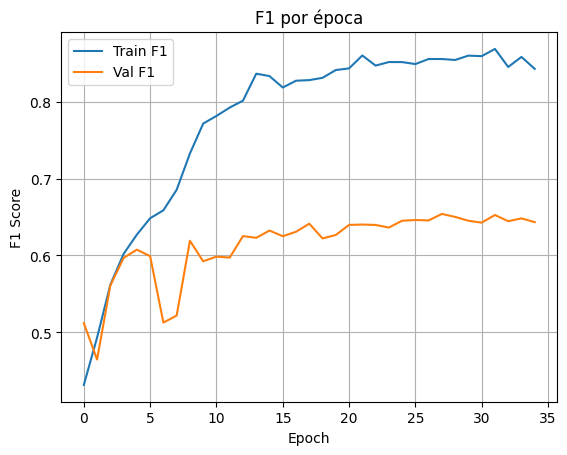

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# --- Configuraciones ---
LABELS_CSV = '/content/sargazo_dataset/labels/labels.csv'
TEST_CSV = '/content/sargazo_dataset/labels/test.csv'
IMG_FOLDER = '/content/sargazo_dataset/images'
class2id = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {v: k for k, v in class2id.items()}
num_classes = len(class2id)

# --- Dataset ---
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label_str = self.dataframe.iloc[idx]['label'].strip().lower()
        label = class2id.get(label_str, class2id['nada'])
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Augmentation ---
input_size = 224
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize(input_size + 32),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- Cargar CSVs ---
labels_df = pd.read_csv(LABELS_CSV)
test_df = pd.read_csv(TEST_CSV)
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)

# --- Pesos para sampler ---
class_counts = train_df['label'].value_counts().to_dict()
weights = train_df['label'].map(lambda x: 1.0 / class_counts[x])
sampler = WeightedRandomSampler(weights.values, num_samples=len(weights), replacement=True)

# --- DataLoaders ---
train_dataset = SargazoDataset(train_df, IMG_FOLDER, transform=train_transform)
val_dataset = SargazoDataset(val_df, IMG_FOLDER, transform=val_transform)
test_dataset = SargazoDataset(test_df.assign(label='nada'), IMG_FOLDER, transform=val_transform)

batch_size = 32
dataloaders_dict = {
    'train': DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# --- Modelo EfficientNet + Fine-tuning ---
def build_model():
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = True
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss

# --- Entrenamiento con Early Stopping ---
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=50, patience=7):
    best_f1 = 0.0
    best_weights = model.state_dict()
    epochs_no_improve = 0
    train_f1_history, val_f1_history = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, preds, targets = 0.0, [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                preds.extend(predicted.cpu().numpy())
                targets.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(targets, preds, average='weighted')

            print(f"{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f}")
            if phase == 'val':
                scheduler.step(epoch_loss)
                val_f1_history.append(epoch_f1)
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_weights = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print("Early stopping")
                        model.load_state_dict(best_weights)
                        return model, train_f1_history, val_f1_history
            else:
                train_f1_history.append(epoch_f1)

    model.load_state_dict(best_weights)
    return model, train_f1_history, val_f1_history

# --- Predicción ---
def predict(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
    return preds

# --- Ejecución ---
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
model = build_model().to(device)
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

model_trained, train_f1_hist, val_f1_hist = train_model(
    model, dataloaders_dict, criterion, optimizer, scheduler, device, num_epochs=50, patience=7
)

# --- Evaluar y generar submission ---
val_preds = predict(model_trained, dataloaders_dict['val'], device)
val_true = [class2id[label.strip().lower()] for label in val_df['label']]
print(classification_report(val_true, val_preds, target_names=class2id.keys()))

test_preds = predict(model_trained, test_loader, device)
test_labels = [id2class[p] for p in test_preds]
submission_df = pd.DataFrame({'image_name': test_df['image_name'], 'label': test_labels})
submission_df.to_csv('submission.csv', index=False)
print("\nArchivo 'submission.csv' creado exitosamente.")

# --- Gráfica de f1 ---
plt.plot(train_f1_hist, label='Train F1')
plt.plot(val_f1_hist, label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 por época')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 1.3653 F1: 0.4111
val Loss: 1.5018 F1: 0.4485
Epoch 2/50
train Loss: 1.2244 F1: 0.4861
val Loss: 1.1060 F1: 0.5559
Epoch 3/50
train Loss: 1.1246 F1: 0.5471
val Loss: 1.0560 F1: 0.5729
Epoch 4/50
train Loss: 1.0572 F1: 0.5649
val Loss: 1.1092 F1: 0.5525
Epoch 5/50
train Loss: 1.1029 F1: 0.5497
val Loss: 1.0483 F1: 0.5514
Epoch 6/50
train Loss: 1.0523 F1: 0.5657
val Loss: 0.9830 F1: 0.5876
Epoch 7/50
train Loss: 0.9589 F1: 0.5980
val Loss: 1.0567 F1: 0.6157
Epoch 8/50
train Loss: 0.9547 F1: 0.6136
val Loss: 1.1672 F1: 0.5324
Epoch 9/50
train Loss: 0.8963 F1: 0.6529
val Loss: 1.0782 F1: 0.5869
Epoch 10/50
train Loss: 0.8967 F1: 0.6349
val Loss: 1.0250 F1: 0.5922
Epoch 11/50
train Loss: 0.7774 F1: 0.6825
val Loss: 1.0558 F1: 0.6286
Epoch 12/50
train Loss: 0.7614 F1: 0.6911
val Loss: 1.0386 F1: 0.6133
Epoch 13/50
train Loss: 0.7053 F1: 0.7202
val Loss: 1.1396 F1: 0.6075
Epoch 14/50
train Loss: 0.6446 F1: 0.7431
val Loss: 1.1872 F1: 0.6309
Epoch 15/50
train Loss: 0.5898 F1: 0.761

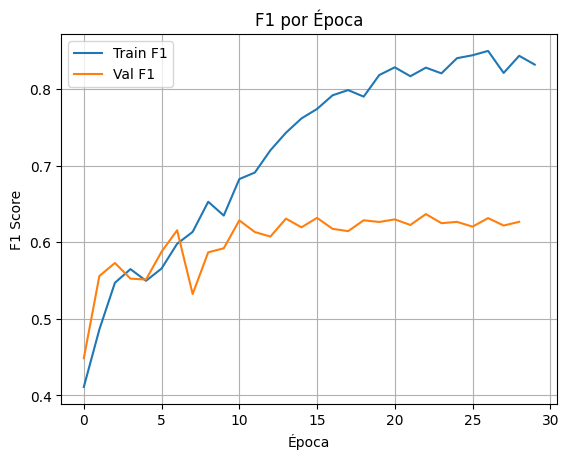

In [ ]:
# Final MobileNetV2 pipeline con mejoras para F1 score
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from torchvision.transforms import InterpolationMode
from torch.optim.lr_scheduler import CosineAnnealingLR

# --- Configuración ---
LABELS_CSV = '/content/sargazo_dataset/labels/labels.csv'
TEST_CSV = '/content/sargazo_dataset/labels/test.csv'
IMG_FOLDER = '/content/sargazo_dataset/images'

class2id = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {v: k for k, v in class2id.items()}
num_classes = len(class2id)
input_size = 224
batch_size = 32

# --- Data augmentation ---
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size, interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# --- Dataset personalizado ---
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label_str = self.dataframe.iloc[idx]['label'].strip().lower()
        label = class2id.get(label_str, class2id['nada'])
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Modelo MobileNetV2 ---
def initialize_model():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model

# --- Entrenamiento ---
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=25, patience=5):
    best_model_wts = model.state_dict()
    best_f1 = 0.0
    train_f1_history = []
    val_f1_history = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            all_preds, all_labels = [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
            print(f"{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f}")

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print("Early stopping")
                        model.load_state_dict(best_model_wts)
                        return model, train_f1_history, val_f1_history

            if phase == 'train':
                train_f1_history.append(epoch_f1)
            else:
                val_f1_history.append(epoch_f1)

    model.load_state_dict(best_model_wts)
    return model, train_f1_history, val_f1_history

# --- Predicción ---
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# --- Carga de datos ---
labels_df = pd.read_csv(LABELS_CSV)
test_df = pd.read_csv(TEST_CSV)
train_df, val_df = train_test_split(labels_df, test_size=0.2, stratify=labels_df['label'], random_state=42)

# --- Sampler para clases desbalanceadas ---
class_counts = train_df['label'].value_counts()
class_weights = 1. / class_counts.loc[train_df['label']].values
sample_weights = torch.DoubleTensor(class_weights)
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_dataset = SargazoDataset(train_df, IMG_FOLDER, transform=data_transforms['train'])
val_dataset = SargazoDataset(val_df, IMG_FOLDER, transform=data_transforms['val'])
test_dataset = SargazoDataset(test_df.assign(label='nada'), IMG_FOLDER, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

dataloaders = {'train': train_loader, 'val': val_loader}

# --- Entrenamiento final ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = initialize_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

model_trained, train_f1, val_f1 = train_model(model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=50, patience=7)

# --- Evaluación y submission ---
val_preds = predict(model_trained, val_loader, device)
val_labels = [class2id[l.strip().lower()] for l in val_df['label']]
print("\nReporte Validación:")
print(classification_report(val_labels, val_preds, target_names=class2id.keys()))

test_preds = predict(model_trained, test_loader, device)
test_classes = [id2class[p] for p in test_preds]
submission_df = pd.DataFrame({'image_name': test_df['image_name'], 'label': test_classes})
submission_df.to_csv('submission.csv', index=False)
print("\nArchivo 'submission.csv' generado con éxito")

# --- Gráfico de métricas ---
plt.plot(train_f1, label='Train F1')
plt.plot(val_f1, label='Val F1')
plt.xlabel('Época')
plt.ylabel('F1 Score')
plt.title('F1 por Época')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Sargazo EfficientNetB2 + Focal Loss + Data Augmentation + Weighted Sampling

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# --- Paths ---
LABELS_CSV = '/content/sargazo_dataset/labels/labels.csv'
TEST_CSV = '/content/sargazo_dataset/labels/test.csv'
IMG_FOLDER = '/content/sargazo_dataset/images'

# --- Classes ---
class2id = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {v: k for k, v in class2id.items()}
num_classes = len(class2id)

# --- Data Augmentation ---
input_size = 260
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.RandomAffine(10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5)
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- Dataset ---
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image_name']
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label_str = self.dataframe.iloc[idx]['label'].strip().lower()
        label = class2id.get(label_str, class2id['nada'])
        if self.transform:
            image = self.transform(image)
        return image, label

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

# --- Load CSVs ---
labels_df = pd.read_csv(LABELS_CSV)
test_df = pd.read_csv(TEST_CSV)

# --- Split ---
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42, stratify=labels_df['label'])

# --- Class weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_tensor = torch.tensor([class_weights[class2id[c]] for c in class2id], dtype=torch.float32)

# --- Weighted Sampler ---
sample_weights = train_df['label'].map(lambda x: 1.0 / class_weights[class2id[x]]).values
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# --- Datasets and Loaders ---
train_ds = SargazoDataset(train_df, IMG_FOLDER, transform=train_transform)
val_ds = SargazoDataset(val_df, IMG_FOLDER, transform=val_transform)
test_ds = SargazoDataset(test_df.assign(label='nada'), IMG_FOLDER, transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# --- Model ---
model = efficientnet_b2(weights=EfficientNet_B2_Weights.DEFAULT)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- Optimizer and Scheduler ---
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-6)
criterion = FocalLoss(alpha=class_weights_tensor.to(device), gamma=2.0)

# --- Train function ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    best_f1 = 0
    train_f1_hist, val_f1_hist = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            loader = train_loader if phase == 'train' else val_loader

            running_loss, preds_all, labels_all = 0.0, [], []

            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                preds = torch.argmax(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                preds_all.extend(preds.cpu().numpy())
                labels_all.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(loader.dataset)
            epoch_f1 = f1_score(labels_all, preds_all, average='weighted')
            if phase == 'val':
                scheduler.step(epoch_f1)
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    torch.save(model.state_dict(), "best_model.pt")
            (train_f1_hist if phase == 'train' else val_f1_hist).append(epoch_f1)
            print(f"{phase} Loss: {epoch_loss:.4f} F1: {epoch_f1:.4f}")
    return train_f1_hist, val_f1_hist

# --- Entrenar ---
num_epochs = 50
train_f1_hist, val_f1_hist = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs)

# --- Inference y Submission ---
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
preds = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds.extend(torch.argmax(outputs, 1).cpu().numpy())
submission_df = pd.DataFrame({
    'image_name': test_df['image_name'],
    'label': [id2class[p] for p in preds]
})
submission_df.to_csv("submission.csv", index=False)
print("\nArchivo 'submission.csv' generado correctamente.")


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 50.4MB/s]

Epoch 1/50


train Loss: 1.0986 F1: 0.2972
val Loss: 1.4518 F1: 0.4607
Epoch 2/50
train Loss: 0.8248 F1: 0.3247
val Loss: 1.3818 F1: 0.5473
Epoch 3/50
train Loss: 0.7240 F1: 0.4479
val Loss: 1.2260 F1: 0.5691
Epoch 4/50
train Loss: 0.6864 F1: 0.4641
val Loss: 1.2313 F1: 0.5690
Epoch 5/50
train Loss: 0.6395 F1: 0.4993
val Loss: 1.2014 F1: 0.5885
Epoch 6/50
train Loss: 0.6194 F1: 0.4855
val Loss: 1.0749 F1: 0.5982
Epoch 7/50
train Loss: 0.5822 F1: 0.5284
val Loss: 1.0733 F1: 0.5820
Epoch 8/50
train Loss: 0.5936 F1: 0.5291
val Loss: 1.1865 F1: 0.6052
Epoch 9/50
train Loss: 0.5448 F1: 0.5492
val Loss: 1.1139 F1: 0.5996
Epoch 10/50
train Loss: 0.5797 F1: 0.5659
val Loss: 1.1220 F1: 0.5986
Epoch 11/50
train Loss: 0.4865 F1: 0.5741
val Loss: 1.0481 F1: 0.6056
Epoch 12/50
train Loss: 0.5147 F1: 0.5766
val Loss: 1.2631 F1: 0.6088
Epoch 13/50
train Loss: 0.4843 F1: 0.5934
val Loss: 1.0696 F1: 0.6049
Epoch 14/50
train Loss: 0.4568 F1: 0.6001
val Loss: 1.0088 F1: 0.6161
Epoch 15/50
train Loss: 0.4209 F1: 0.631

In [ ]:
from google.colab import files

files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>